## Neural Network classification with pytorch

Classification is a problem of predicting whether something is one thing or another

In [184]:
import torch
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from helper_functions import plot_predictions, plot_decision_boundary
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Making artificial dataset

NOTE: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

In [185]:
# Making artificial data
n_spls = 1000

# Creating circles
X,y = make_circles(n_spls,
                   noise = 0.03,
                   random_state=42)

In [186]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")


First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [187]:
# Making datafram of circle data
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label" : y})

In [188]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


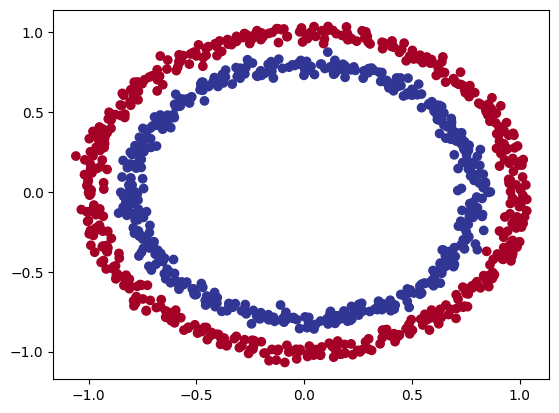

In [189]:
# Visualizing
plt.scatter(X[:,0],X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Checking input and output shapes

In [190]:
X.shape, y.shape

((1000, 2), (1000,))

In [191]:
 #View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(F"Values for one sample of x: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of x: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [192]:
X = torch.tensor(circles[["X1","X2"]].values).type(torch.float32).to(device)
y = torch.tensor(circles["label"].values).type(torch.float32).unsqueeze(dim=1).to(device)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

In [193]:
X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]], device='cuda:0')

## 2. Building a model

In [194]:
# 1. Construct a model that subclasses nn.Module
from torch import nn
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2,out_features=100) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features = 100, out_features=1) # takes in the 5 features from previous layer and outputs a single feature (same shape as y)
    
    # Defining the forward method
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # X -> layer_1 -> layer_2 -> output
    
# 4. Creating an instance of the model 
model = CircleModel().to(device)


### same model using sequential

In [195]:
# Replicating the model with nn.Sequential
model_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5,out_features=1)
)

## Training and Testing loop

In [196]:
## Creating training and test loops
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)
loss_fn = nn.BCEWithLogitsLoss()

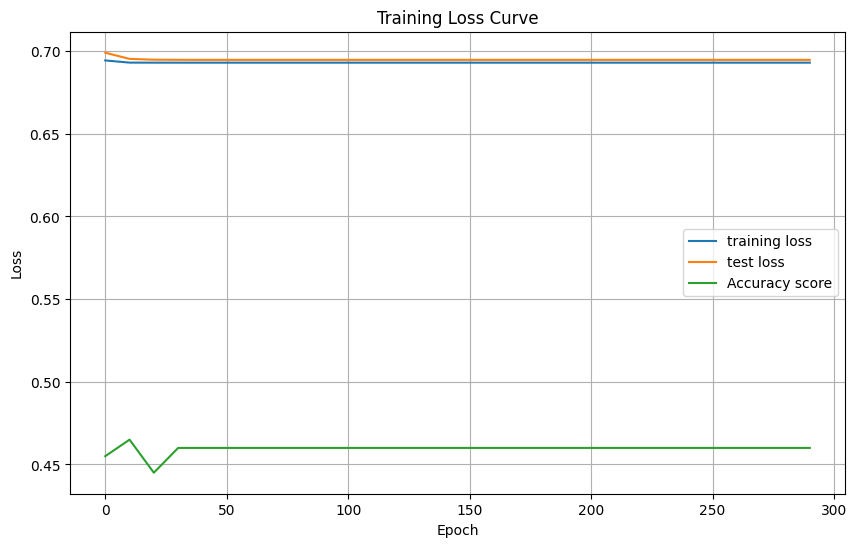

In [197]:
# Epoc is a loop through the data
epochs = 300
epoch_count = []

model.to(device)

lossval = []
test_loss_vals = []
acc_score = []
#0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model.train() # Train mode in PyTorch sets all parameters that require grads to have gradients
    
    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Loss
    loss = loss_fn(y_pred,y_train)

    # 3. Set grads to zero
    optimizer.zero_grad()

    #4. Backward Pass
    loss.backward()

    #5. Update value
    optimizer.step()
    
    # Testing
    if epoch % 10==0:
        model.eval() 
        with torch.inference_mode():
            # 1. forward pass (outputs raw logits)
            test_logits = model(X_test)

            #2. Calculate the loss (using logits)
            test_loss = loss_fn(test_logits,y_test)

            # To get predictions:
            # Pass logits through sigmoid
            test_pred_probs = torch.sigmoid(test_logits)
            # Round to get 0 or 1
            test_preds_binary = torch.round(test_pred_probs)

            acc_score.append(accuracy_score(test_preds_binary.cpu(),y_test.cpu()))
            lossval.append(loss.item())
            epoch_count.append(epoch)
            test_loss_vals.append(test_loss.item())


            
plt.figure(figsize=(10, 6))
plt.plot(epoch_count,lossval, label = "training loss")
plt.plot(epoch_count,test_loss_vals, label = "test loss")
plt.plot(epoch_count, acc_score, label = "Accuracy score")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()

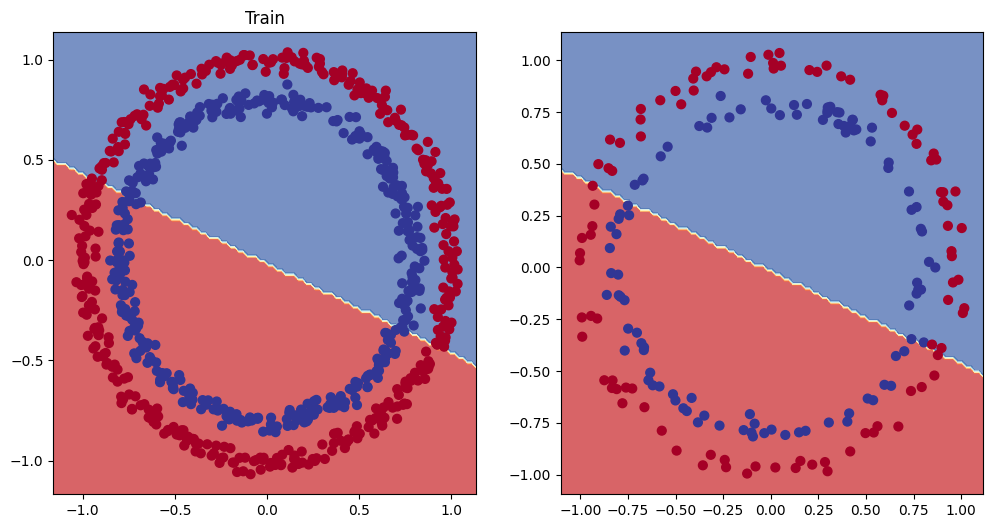

In [198]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_train,y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model,X_test,y_test)

## 4. Steps to improve the model further

* Add more layers - give the model more chances to learrn about patterns in the data.
* Add more hidden units _ go from 5 hidden units to 10 hidden units
* Fit for longer 
* Changing the activation functions
* Change the learning rate
* Change the loss functions
* Change the optimizer


In [199]:
# Improving the model by adding a non-linear activation function
from torch import nn

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data and a non-linear activation
        self.layer_1 = nn.Linear(in_features=2, out_features=64)  # input layer: takes 2 input features and projects to 64-dimensional space
        self.relu = nn.ReLU()  # non-linear activation to allow the model to learn complex patterns
        self.layer_2 = nn.Linear(in_features=64, out_features=1)  # output layer: reduces the 64 features to a single output (same shape as y)
    
    # Defining the forward method
    def forward(self, x):
        return self.layer_2(self.relu(self.layer_1(x)))  # x -> layer_1 -> ReLU -> layer_2 -> output

# 4. Creating an instance of the model 
model_1 = CircleModel().to(device)


## Training the New Model

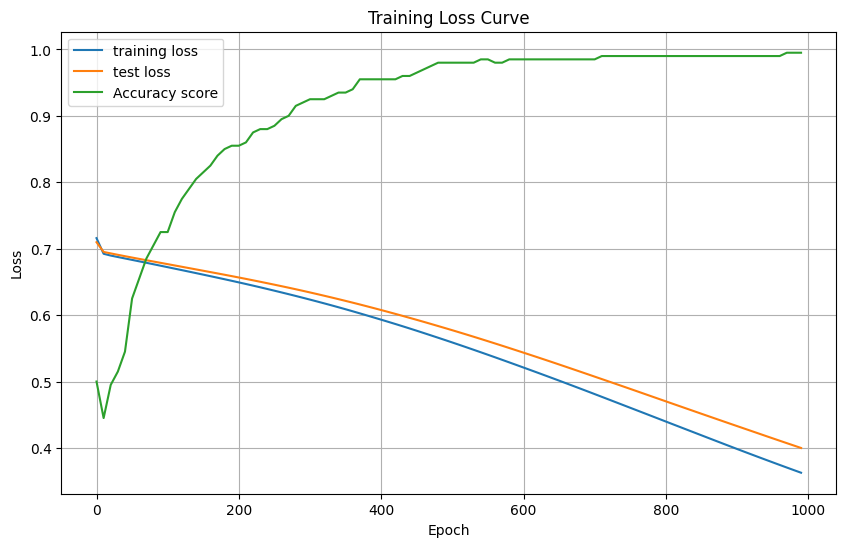

In [200]:
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)
loss_fn = nn.BCEWithLogitsLoss()

model_1.to(device)

epochs = 1000
epoch_count = []
lossval = []
test_loss_vals = []
acc_score = []
#0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_1.train()
    
    # 1. Forward pass
    y_pred = model_1(X_train)
    # 2. Loss
    loss = loss_fn(y_pred,y_train)
    # 3. Set grads to zero
    optimizer.zero_grad()
    #4. Backward Pass
    loss.backward()
    #5. Update value
    optimizer.step()
    
    # Testing
    if epoch % 10==0:
        model.eval() 
        with torch.inference_mode():
            # 1. forward pass (outputs raw logits)
            test_logits = model_1(X_test)

            #2. Calculate the loss (using logits)
            test_loss = loss_fn(test_logits,y_test)

            # To get predictions:
            # Pass logits through sigmoid
            test_pred_probs = torch.sigmoid(test_logits)
            # Round to get 0 or 1
            test_preds_binary = torch.round(test_pred_probs)

            acc_score.append(accuracy_score(test_preds_binary.cpu(),y_test.cpu()))
            lossval.append(loss.item())
            epoch_count.append(epoch)
            test_loss_vals.append(test_loss.item())


            
plt.figure(figsize=(10, 6))
plt.plot(epoch_count,lossval, label = "training loss")
plt.plot(epoch_count,test_loss_vals, label = "test loss")
plt.plot(epoch_count, acc_score, label = "Accuracy score")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()

## Comparing the old and new model

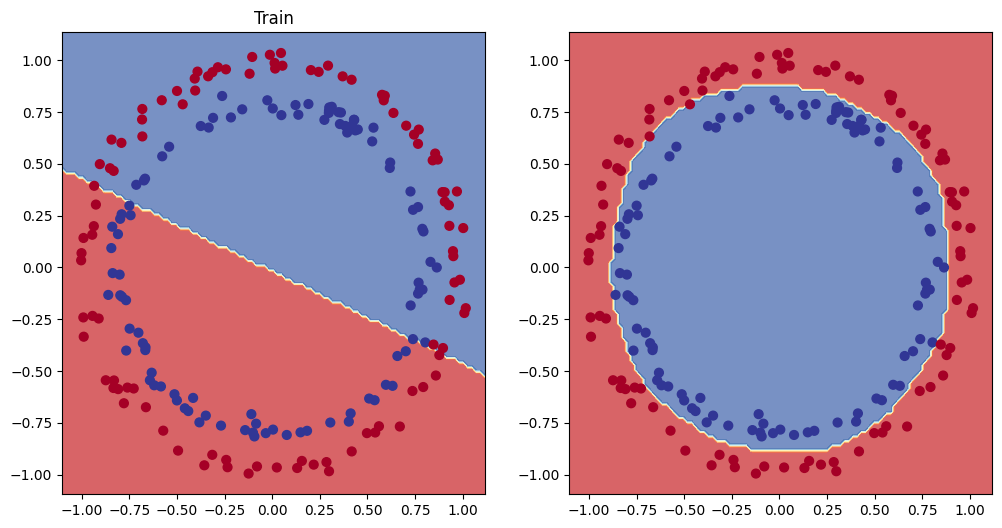

In [201]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_test,y_test)
plt.subplot(1,2,2)
plot_decision_boundary(model_1,X_test,y_test)

# Finishing off with a multi class problem
In a multi-class classification problem, the goal is to categorize inputs into one of three or more classes, rather than just two (as in binary classification). 

**Key changes from binary classification:**
- **Output Layer:** The model's output layer now has as many units as there are classes, instead of just one.
- **Activation Function:** For multi-class, we typically use `softmax` activation (implicitly handled by `CrossEntropyLoss` in PyTorch), which outputs a probability distribution over all classes.
- **Loss Function:** We use `CrossEntropyLoss` instead of `BCEWithLogitsLoss`. `CrossEntropyLoss` combines `LogSoftmax` and `NLLLoss` in one single class.
- **Labels:** The target labels are integer class indices (e.g., 0, 1, 2, ...) rather than floating-point 0/1 values.
- **Prediction:** The predicted class is the index of the highest output value (using `argmax`), not a thresholded probability.

These changes allow the model to learn to distinguish between multiple categories, making it suitable for tasks like digit recognition, disease classification, and more.

## Loading a multi class dataset from kaggle

In [202]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:",device)


Using Device: cuda


In [203]:
data = pd.read_csv("../Datasets/dermatology_database_1.csv")
data.head()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_granular_layer,vacuolisation_damage_basal_layer,spongiosis,saw_tooth_appearance_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_mononuclear_infiltrate,band_like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3


In [204]:
data.isnull().sum()

erythema                               0
scaling                                0
definite_borders                       0
itching                                0
koebner_phenomenon                     0
polygonal_papules                      0
follicular_papules                     0
oral_mucosal_involvement               0
knee_and_elbow_involvement             0
scalp_involvement                      0
family_history                         0
melanin_incontinence                   0
eosinophils_infiltrate                 0
PNL_infiltrate                         0
fibrosis_papillary_dermis              0
exocytosis                             0
acanthosis                             0
hyperkeratosis                         0
parakeratosis                          0
clubbing_rete_ridges                   0
elongation_rete_ridges                 0
thinning_suprapapillary_epidermis      0
spongiform_pustule                     0
munro_microabcess                      0
focal_hypergranu

In [205]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   erythema                             366 non-null    int64 
 1   scaling                              366 non-null    int64 
 2   definite_borders                     366 non-null    int64 
 3   itching                              366 non-null    int64 
 4   koebner_phenomenon                   366 non-null    int64 
 5   polygonal_papules                    366 non-null    int64 
 6   follicular_papules                   366 non-null    int64 
 7   oral_mucosal_involvement             366 non-null    int64 
 8   knee_and_elbow_involvement           366 non-null    int64 
 9   scalp_involvement                    366 non-null    int64 
 10  family_history                       366 non-null    int64 
 11  melanin_incontinence                 366 non-

In [206]:
data['age'].unique()

array(['55', '8', '26', '40', '45', '41', '18', '57', '22', '30', '20',
       '21', '10', '65', '38', '23', '17', '51', '42', '44', '33', '43',
       '50', '34', '?', '15', '46', '62', '35', '48', '12', '52', '60',
       '32', '19', '29', '25', '36', '13', '27', '31', '28', '64', '39',
       '47', '16', '0', '7', '70', '37', '61', '67', '56', '53', '24',
       '58', '49', '63', '68', '9', '75'], dtype=object)

In [207]:
data['age'] = data['age'].replace({'?':np.nan}).astype(float)
data['age'] = data['age'].fillna(data['age'].mean())
class_no = data['class'].nunique()
data['class'].unique()

array([2, 1, 3, 5, 4, 6])

In [208]:
X = torch.tensor(data.iloc[:,:-1].values).type(torch.float32).to(device)
y = torch.tensor(data.iloc[:,-1].values-1).type(torch.long).to(device)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

## Creating the model

In [209]:
class dermo_classifier(nn.Module):
    def __init__(self,inp,out):
        super().__init__()

        #Layers
        self.inlayer = nn.Linear(in_features=inp,out_features=128)
        self.relu = nn.ReLU()
        self.hlayer1 = nn.Linear(in_features=128,out_features=128)
        self.outlayer = nn.Linear(in_features=128,out_features=out)

    def forward(self,X):
        X = self.inlayer(X)
        X = self.relu(X)
        X = self.hlayer1(X)
        X = self.relu(X)
        return self.outlayer(X)
    
model = dermo_classifier(inp = X.shape[1],out=class_no).to(device)

## Training and Testing

In [210]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

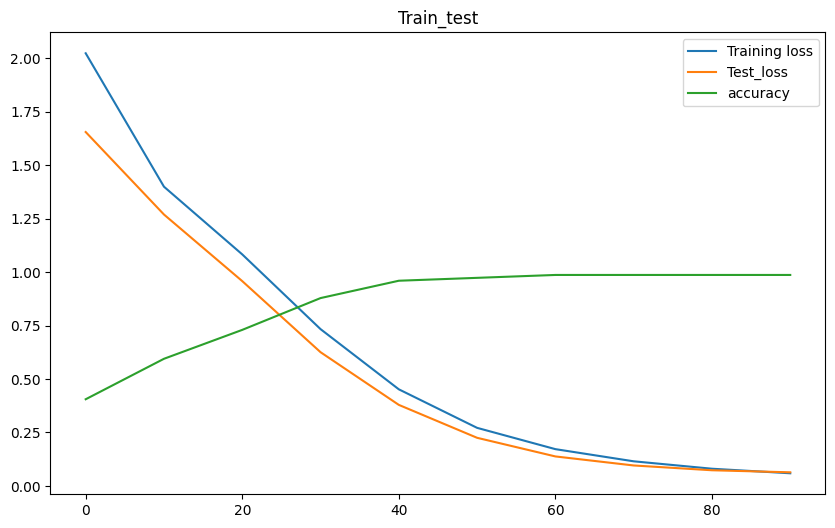

Final training loss: 0.04662443697452545 | Final test loss: 0.0638655498623848 | Final model accuracy: 0.9864864864864865%
time taken 0.1371302604675293


In [ ]:
epochs = 100
loss_val = []
test_loss_val = []
accuracy = []
ep =[]
for epoch in range(epochs):
    # Training
    model.train()
    pred = model(X_train)
    loss = loss_fn(pred,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%10 == 0:
        ep.append(epoch)
        model.eval()

        with torch.inference_mode():
            test_pred = model(X_test)
            test_loss = loss_fn(test_pred,y_test)
            pred_cls = torch.argmax(test_pred, dim=1)
            # Calculate accuracy
            correct = (pred_cls == y_test).sum().item()
            total = y_test.shape[0]
            acc = correct / total
            accuracy.append(acc)

            loss_val.append(loss.item())
            test_loss_val.append(test_loss.item())

plt.figure(figsize=(10,6))
plt.title("Train_test")
plt.plot(ep,loss_val,label = 'Training loss')
plt.plot(ep,test_loss_val,label = 'Test_loss')
plt.plot(ep,accuracy,label = "accuracy")
plt.legend()
plt.show()

print(f"Final training loss: {loss.item()} | Final test loss: {test_loss.item()} | Final model accuracy: {acc}%")

## Evaluation

In [213]:
from torchmetrics import Accuracy,F1Score,Precision,Recall
acc = Accuracy(task="multiclass", num_classes=class_no).to(device)
f1 = F1Score(task="multiclass", num_classes=class_no).to(device)
prec = Precision(task="multiclass", num_classes=class_no).to(device)
rec = Recall(task="multiclass", num_classes=class_no).to(device)


In [214]:
model.eval()
with torch.inference_mode():
    y_pred = torch.argmax(model(X_test),dim=1)

print(f'''Model Metrics
Accuracy:- {acc(y_pred,y_test)} 
F1Score:- {f1(y_pred,y_test)} 
Precision:- {prec(y_pred,y_test)} 
Recall:- {rec(y_pred,y_test)} ''')

Model Metrics
Accuracy:- 0.9864864945411682 
F1Score:- 0.9864864945411682 
Precision:- 0.9864864945411682 
Recall:- 0.9864864945411682 
